# TRABALHO PRÁTICO 1: COMPRESSÃO DE IMAGENS
**Alunos:** Luís Antônio Duarte Sousa e Luiz Felipe Lima Costa.

## OBJETIVO
O objetivo deste trabalho foi desenvolver um algoritmo para compressão e descompressão de imagens digitais. 

## MÉTODO
O método proposto combina a Transformada Discreta do Cosseno (DCT) com a quantização e a codificação de Shannon-Fano, com o intuito de reduzir o tamanho da imagem mantendo a qualidade perceptível.

Inicialmente, a imagem é transformada para o domínio das frequências utilizando a Transformada Discreta do Cosseno (DCT). Essa transformação converte a imagem do espaço de pixels para um espaço de coeficientes de frequência, onde as informações mais significativas são concentradas nas frequências baixas, e as frequências altas, que são menos perceptíveis ao olho humano, podem ser descartadas. Em seguida, as frequências baixas da imagem são quantizadas, o que reduz a precisão dos coeficientes de acordo com uma tabela de quantização. Esse processo tem como objetivo diminuir a quantidade de dados necessários para representar a imagem sem afetar significativamente a percepção visual da imagem.

Após a quantização, os coeficientes da imagem são codificados utilizando o algoritmo de Shannon-Fano. Esse algoritmo de codificação é baseado em uma técnica eficiente de compressão, onde os coeficientes mais frequentes recebem códigos mais curtos, enquanto os menos frequentes são representados por códigos mais longos. Esse processo visa reduzir a redundância nos dados, resultando em uma compressão adicional.

Por fim, a descompressão é realizada através de um processo inverso. Os dados comprimidos são primeiramente decodificados utilizando o algoritmo de Shannon-Fano. Em seguida, os coeficientes quantizados são desquantizados, e a Transformada Discreta do Cosseno é aplicada para reconstruir uma aproximação da imagem original.

# ETAPAS DO PROCESSO DE COMPRESSÃO

- Redução de profundidade para 5 bits.

- Transformada do Cosseno. 

- Quantização. 

- Ordenação ZigZag.

- Codificação de Shanno-fano.


# IMPORTAÇÃO
- Bibliotecas utilizadas para a execução deste trabalho.

In [1]:
import cv2 as opencv
import numpy as np
from scipy import fftpack 
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter

# RMSE

- Mede a diferença entre a imagem original e a reconstruída, quantificando o erro médio ao longo dos pixels.

In [2]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# PSNR
- Avalia a qualidade da imagem reconstruída em comparação com a original, expressando a relação entre o sinal útil e o ruído de compressão.

In [3]:
def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

# DCT 2D

- Retorna a transformada do cosseno do bloco (Espacial -> Frequencia).

In [4]:
def DCT(bloco):
   return fftpack.dct(fftpack.dct(bloco.T, norm='ortho').T, norm='ortho')

# DCT 2D INVERSA

- Retorna a inversa da transfromada do cosseno do bloco (Frequencia -> Espacial)

In [5]:
def IDCT(bloco_coef):
    return fftpack.idct(fftpack.idct(bloco_coef.T, norm='ortho').T, norm='ortho')

# AJUSTE DE DIMENSÕES

- Verifica se as dimensões da imagem são múltiplas de 8 e, caso necessário, faz o ajuste preenchendo com zeros.

In [6]:
def ajustar_dimensoes(img, bloco_size=8):
    # Obtém as dimensões da imagem original
    altura, largura = img.shape
    
    # Calcula a nova altura e largura como múltiplos do tamanho do bloco
    nova_altura = ((altura + bloco_size - 1) // bloco_size) * bloco_size
    nova_largura = ((largura + bloco_size - 1) // bloco_size) * bloco_size
    
    # Cria uma nova matriz com as dimensões ajustadas, preenchida com zeros
    nova_img = np.zeros((nova_altura, nova_largura), dtype=img.dtype)
    
    # Copia os dados da imagem original para a nova matriz
    nova_img[:altura, :largura] = img
    
    return nova_img

# LEITURA

- Leitura e visualização da imagem original. 

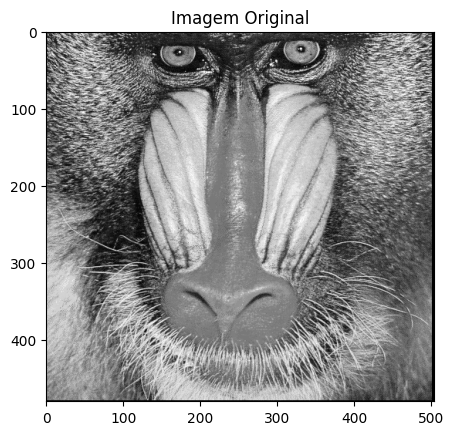

In [7]:
# Lê a imagem em escala de cinza a partir do arquivo 'cameraman.pgm'
img = opencv.imread('./baboon.pgm', 0)

# Ajusta as dimensões da imagem para serem múltiplas do tamanho do bloco
img = ajustar_dimensoes(img)

# Exibe a imagem ajustada em escala de cinza
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')  # Adiciona o título à imagem exibida
plt.show()  # Mostra a imagem na tela


# COMPRESSÃO PSICOVISUAL

- A ideia da compressão psicovisual está em aproveitar características perceptivas humanas, como a sensibilidade ao brilho e à cor, para descartar informações que terão menor impacto visual para o observador.

- É possivel observar que a imagem do bloco anterior e do bloco seguinte são praticamente identicas entretanto a entropia da original é proxima de 8 enquanto da com 5 bits é proxima de 4 e isso demonstra que menos tons de cinza estão sendo usados na segunda imagem sem causar uma discrepancia visual.


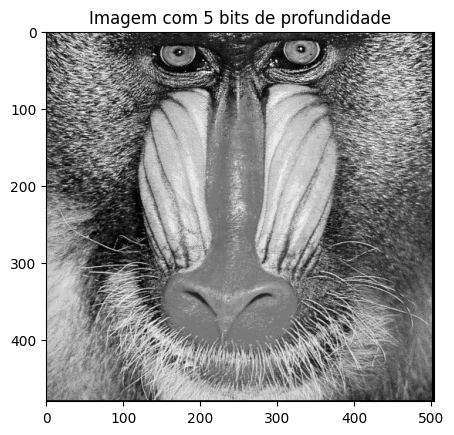

In [8]:
# Reduz a profundidade de bits da imagem para 5 bits (compressão psicovisual)
img = img & 0xF8

# Salva a imagem original antes da conversão para tipo float
img_en = img

# Converte a imagem para o tipo float para processamento posterior
img = img.astype(float)

# Exibe a imagem resultante em escala de cinza
plt.imshow(img, cmap='gray')
plt.title('Imagem com 5 bits de profundidade')  # Define o título da imagem exibida
plt.show()  # Mostra a imagem na tela

# INICIALIZAÇÃO

- Cria matrizes float populadas com 0 que representam os coeficientes da transformada e a sua inversa.

In [9]:
img = img - 128                              # Centraliza os valores dos pixels ao redor de zero
size = img.shape                             # Obtém o tamanho da imagem
print(size)

                     
IDCT_matrix = np.zeros(size, dtype=float)    # Inicializa a matriz para a inversa da DCT
DCT_matrix = np.zeros(size, dtype=float)    # Inicializa a matriz para armazenar os coeficientes da DCT

print(DCT_matrix.size)

(480, 504)
241920


# DIVIDIR IMAGEM

- Itera sobre a imagem em blocos de tamanho 8x8, aplica DCT e salva na matriz de coeficientes DCT_matrix. Analogamente, pega os coeficientes e aplica a inversa do DCT, salvando o resultado na matriz IDCT_matrix.
    

In [10]:
# Percorre a imagem em blocos de 8x8 pixels
for y in range(0, size[0], 8):  # Itera sobre as linhas com passo de 8
    for x in range(0, size[1], 8):  # Itera sobre as colunas com passo de 8
        # Aplica a Transformada Discreta de Cosseno (DCT) no bloco atual
        dct = DCT(img[y:y+8, x:x+8])
        
        # Aplica a Transformada Inversa de Cosseno (IDCT) no bloco transformado
        idct = IDCT(dct)
        
        # Armazena o resultado da IDCT na matriz correspondente
        IDCT_matrix[y:y+8, x:x+8] = idct
        
        # Armazena o resultado da DCT na matriz correspondente
        DCT_matrix[y:y+8, x:x+8] = dct

# Ajusta os valores da imagem original para compensar o deslocamento de -128 realizado anteriormente
img = img + 128

# Ajusta os valores da matriz da IDCT da mesma forma
IDCT_matrix = IDCT_matrix + 128

# VISUALIZAÇÃO DE TRANSFORMADA

- Mudança de dominio espacial para dominio de frequencia e retorno sem alterar os coeficientes 
- O RSMR será 0 uma vez que nenhuma informação foi perdida apenas uma mudança de dominio

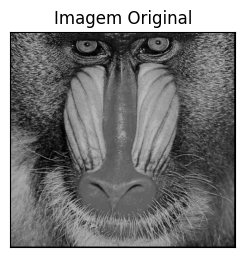

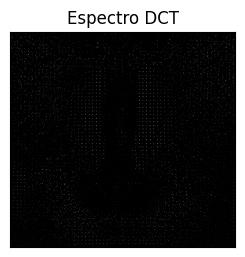

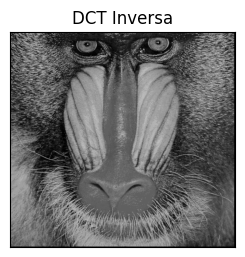

RMSE: 0.000


In [11]:
# Exibe a imagem original ajustada
plt.subplot(121)  # Define a posição do subplot
plt.imshow(img, cmap='gray', clim=(0, 255))  # Mostra a imagem em tons de cinza com escala de 0 a 255
plt.title('Imagem Original')  # Define o título do gráfico
plt.xticks([]), plt.yticks([])  # Remove os ticks dos eixos
plt.show()  # Exibe o gráfico

# Exibe o espectro da Transformada Discreta de Cosseno (DCT)
plt.subplot(121)  # Define a posição do subplot
plt.imshow(DCT_matrix, cmap='gray', clim=(0, 255))  # Mostra o espectro DCT em tons de cinza com escala de 0 a 255
plt.title('Espectro DCT')  # Define o título do gráfico
plt.xticks([]), plt.yticks([])  # Remove os ticks dos eixos
plt.show()  # Exibe o gráfico

# Exibe a imagem reconstruída após a Transformada Inversa de Cosseno (IDCT)
plt.subplot(121)  # Define a posição do subplot
plt.imshow(IDCT_matrix, cmap='gray', clim=(0, 255))  # Mostra a imagem reconstruída em tons de cinza com escala de 0 a 255
plt.title('DCT Inversa')  # Define o título do gráfico
plt.xticks([]), plt.yticks([])  # Remove os ticks dos eixos
plt.show()  # Exibe o gráfico

# Calcula e exibe o erro quadrático médio (RMSE) entre a imagem original e a reconstruída
print("RMSE: %5.3f" % rmse(img, IDCT_matrix))  # Imprime o valor do RMSE formatado com 3 casas decimais

# QUANTIZAÇÃO
-  Reduz a precisão dos coeficientes DCT para reduzir o tamanho dos dados, aproximando valores contínuos a valores discretos, o que pode resultar em perdas de informação.


Coeficientes Originais:
[[-8.65000000e+02  1.42904540e+02 -2.38895517e+00 -5.11442394e+01
   3.00000000e+00  3.79671591e+01  2.07192983e+00 -2.86540428e+01]
 [ 5.04221890e+01  4.15547279e+01 -8.57954451e+00 -1.91866047e+01
   6.28430821e+00  1.64670473e+01 -4.29116398e+00 -1.75450130e+01]
 [-1.32898004e+01 -1.71996029e+01 -1.07781746e+01 -3.51064026e-01
   5.45042262e+00 -6.15856612e-01 -1.17781746e+01 -1.28410078e+01]
 [ 2.68968368e+01  2.33461934e+01 -2.20368699e+00 -9.99391386e+00
  -8.17842800e-01  2.20989148e+00 -7.45729725e+00 -1.16090281e+01]
 [-2.10000000e+01 -1.91194081e+01 -2.24170765e-01  6.29905777e+00
  -1.00000000e+00 -6.70078466e+00 -3.15432203e+00  1.36732917e+00]
 [ 1.55665122e+01  1.08811060e+01 -6.67958470e+00 -7.30482715e+00
   5.26063484e+00  8.53806974e+00 -2.37924266e+00 -8.69543712e+00]
 [-8.56628303e+00 -9.62061617e+00 -3.77817459e+00  2.00102352e+00
   5.31910643e+00  5.93953568e+00  4.77817459e+00  2.63461936e+00]
 [ 7.99041466e+00  8.94026836e+00  3.6220626

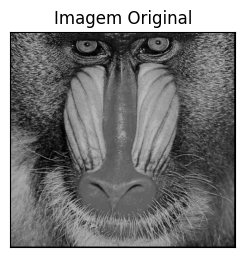

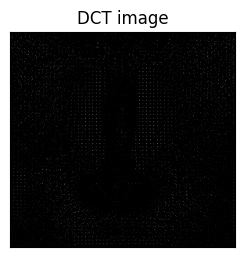

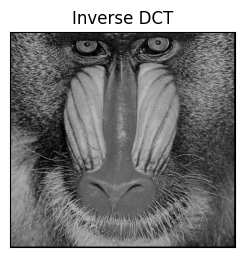

RMSE: 10.644
PSNR: 27.589


In [12]:
# Define a matriz de quantização usada para compressão

QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])


# Matriz de quantização para compressão mais suave. 
# Essa matriz foi utilizada para testes de comparação (ver seção de análise de resultados).

"""
QM = np.matrix([[8, 6, 5, 8, 12, 20, 26, 31],
                      [6, 6, 7, 10, 13, 29, 30, 28],
                      [7, 6, 8, 12, 20, 28, 34, 28],
                      [7, 9, 11, 15, 26, 44, 40, 31],
                      [9, 11, 19, 28, 34, 55, 52, 39],
                      [12, 17, 28, 32, 41, 52, 56, 46],
                      [25, 32, 39, 44, 52, 61, 60, 51],
                      [36, 46, 48, 49, 56, 50, 52, 49]])
"""

QM = QM.astype(float)  # Converte a matriz de quantização para float

# Inicializa a matriz de coeficientes quantizados
Coeficientes_quantizados = np.zeros(size, dtype=float)

# Itera sobre os blocos 8x8 da imagem
for y in range(0, size[0], 8):
    for x in range(0, size[1], 8):
        bloco_dct = DCT_matrix[y:y+8, x:x+8]  # Extrai o bloco DCT atual
        bloco_original = bloco_dct  # Salva o bloco original antes da quantização
        
        # Divide os coeficientes DCT pela matriz de quantização
        bloco_dct = np.divide(bloco_dct, QM)
        bloco_dct = bloco_dct.round()  # Arredonda os valores para inteiros
        bloco_quantizado = bloco_dct  # Salva o bloco após a quantização
        Coeficientes_quantizados[y:y+8, x:x+8] = bloco_quantizado  # Armazena na matriz final
        
        # Reverte a quantização multiplicando pela matriz de quantização
        bloco_dct = np.multiply(bloco_dct, QM)
        IDCT_matrix[y:y+8, x:x+8] = IDCT(bloco_dct)  # Aplica a IDCT ao bloco quantizado
        
# Exibe os coeficientes originais, quantizados e reconstruídos
print("\nCoeficientes Originais:")      
print(bloco_original)

print("\nCoeficientes Quantizados:")
print(bloco_quantizado)

print("\nMatriz Reconstruída com perdas:")
print(bloco_dct)

# Substitui valores -0 por 0 na matriz de coeficientes quantizados
Coeficientes_quantizados[Coeficientes_quantizados == -0] = 0
print(Coeficientes_quantizados[0])  # Exibe os coeficientes quantizados da primeira linha

# Ajusta a matriz reconstruída para o intervalo adequado
IDCT_matrix = IDCT_matrix + 128

# Exibe a imagem original
plt.subplot(121), plt.imshow(img, cmap='gray', clim=(0, 255))
plt.title('Imagem Original'), plt.xticks([]), plt.yticks([])
plt.show()

# Exibe a imagem DCT
plt.subplot(121), plt.imshow(DCT_matrix, cmap='gray', clim=(0, 255))
plt.title('DCT image'), plt.xticks([]), plt.yticks([])
plt.show()

# Exibe a imagem após a IDCT
plt.subplot(121), plt.imshow(IDCT_matrix, cmap='gray', clim=(0, 255))
plt.title('Inverse DCT'), plt.xticks([]), plt.yticks([])
plt.show()

# Calcula e exibe os valores de RMSE e PSNR
print("RMSE: %5.3f" % rmse(img, IDCT_matrix))
print("PSNR: %5.3f" % psnr(img, IDCT_matrix))


# ORDENAÇÃO ZIG-ZAG 

- Define a função de ordenação Zig-Zag. 

In [13]:
def zigzag(matrix):
    rows, cols = matrix.shape  # Obtém o número de linhas e colunas da matriz
    solution = []  # Lista para armazenar os elementos na ordem zig-zag

    # Itera sobre todas as diagonais da matriz
    for s in range(rows + cols - 1):
        if s % 2 == 0:  # Para diagonais pares, percorre de cima para baixo
            for i in range(s + 1):
                # Verifica se os índices estão dentro dos limites da matriz
                if i < rows and s - i < cols:
                    solution.append(matrix[i, s - i])  # Adiciona o elemento à solução
        else:  # Para diagonais ímpares, percorre de baixo para cima
            for i in range(s + 1):
                # Verifica se os índices estão dentro dos limites da matriz
                if s - i < rows and i < cols:
                    solution.append(matrix[s - i, i])  # Adiciona o elemento à solução
    return solution  # Retorna a lista de elementos na ordem zig-zag

# APLICANDO ORDENAÇÃO

In [14]:
complete_sequence = []  # Lista para armazenar as sequências zig-zag de todos os blocos

# Percorre a imagem em blocos de 8x8
for y in range(0, size[0], 8):
    for x in range(0, size[1], 8):
        # Obter o bloco DCT atual com base nas coordenadas
        bloco_dct = Coeficientes_quantizados[y:y+8, x:x+8]
        
        # Aplicar a ordenação zig-zag no bloco atual
        zigzag_sequence = zigzag(bloco_dct)
        
        # Adicionar a sequência zig-zag à lista completa
        complete_sequence.append(zigzag_sequence)
        
        # Exibir o índice do bloco e sua sequência zig-zag
        print(f"\nBloco ({y//8}, {x//8}):")
        print("Sequência Zigzag:", zigzag_sequence)


Bloco (0, 0):
Sequência Zigzag: [np.float64(-38.0), np.float64(-2.0), np.float64(4.0), np.float64(2.0), np.float64(-3.0), np.float64(-5.0), np.float64(-7.0), np.float64(-2.0), np.float64(4.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(2.0), np.float64(3.0), np.float64(-5.0), np.float64(-4.0), np.float64(-1.0), np.float64(-3.0), np.float64(4.0), np.float64(-2.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(0.0), np.float64(-2.0), np.float64(-1.0), np.float64(-1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Bloco (45, 28):
Sequência Zigzag: [np.float64(-8.0), np.float64(0.0), np.float64(-1.0), np.float64(1.0), np.float64(0.0), np.float64(-1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float6

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# FLAG DE 0s
- Define a função que aplica flag de 0s à sequência de Zig-Zag.

In [15]:
def apply_flag_to_zigzag_sequence(zigzag_sequence):
    # Inicializa a variável que irá armazenar o índice do último valor não-zero
    last_non_zero_index = -1  

    # Percorre a sequência de trás para frente, começando do índice 35 (heurística) até 0
    for i in range(35, -1, -1):  # Começa do índice 35 e vai até 0
        if zigzag_sequence[i] != 0:  # Se encontrar um valor não-zero
            last_non_zero_index = i  # Atualiza o índice do último valor não-zero
            break  # Sai do loop, pois já encontrou o último valor significativo
    
    # Se houver valores não-zero na sequência, coloca a flag após o último valor não-zero
    if last_non_zero_index != -1:
        # Mantém a sequência até o último valor não-zero, adiciona a flag (-999) e descarta os zeros restantes
        zigzag_sequence = zigzag_sequence[:last_non_zero_index + 1] + [-999]
    else:
        # Se todos os valores forem zero, apenas adiciona a flag
        zigzag_sequence = [-999]
    
    # Retorna a sequência com a flag aplicada
    return zigzag_sequence

# APLICANDO FLAG

In [16]:
# Para cada sequência de zigzag na lista complete_sequence
for i, seq in enumerate(complete_sequence):
    # Aplica a flag à sequência de zigzag, modificando a sequência no índice correspondente
    complete_sequence[i] = apply_flag_to_zigzag_sequence(seq)

# Imprime a primeira sequência com a flag aplicada
print(complete_sequence[0])

# Imprime a segunda sequência com a flag aplicada
print(complete_sequence[1])   

[np.float64(-38.0), np.float64(-2.0), np.float64(4.0), np.float64(2.0), np.float64(-3.0), np.float64(-5.0), np.float64(-7.0), np.float64(-2.0), np.float64(4.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(2.0), np.float64(3.0), np.float64(-5.0), np.float64(-4.0), np.float64(-1.0), np.float64(-3.0), np.float64(4.0), np.float64(-2.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(0.0), np.float64(-2.0), np.float64(-1.0), np.float64(-1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), -999]
[np.float64(-24.0), np.float64(-18.0), np.float64(-8.0), np.float64(0.0), np.float64(6.0), np.float64(-11.0), np.float64(1.0), np.float64(1.0), np.float64(-4.0), np.float64(2.0), np.float64(0.0), np.float64(4.0), np.float64(1.0), np.float64(0.0), np.float64(-6.0), np.float64(0.0), np.float64(2.0), np.float64(0.0), np.float64(-2.0), np.float64(0.0), np.float64(0

# UNIÃO DAS SEQUÊNCIAS

In [17]:
all_sequences = []
for seq in complete_sequence:
   all_sequences.extend(seq)  # Une as sequencias dos blocos 

print(all_sequences)

[np.float64(-38.0), np.float64(-2.0), np.float64(4.0), np.float64(2.0), np.float64(-3.0), np.float64(-5.0), np.float64(-7.0), np.float64(-2.0), np.float64(4.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(2.0), np.float64(3.0), np.float64(-5.0), np.float64(-4.0), np.float64(-1.0), np.float64(-3.0), np.float64(4.0), np.float64(-2.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(0.0), np.float64(-2.0), np.float64(-1.0), np.float64(-1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), -999, np.float64(-24.0), np.float64(-18.0), np.float64(-8.0), np.float64(0.0), np.float64(6.0), np.float64(-11.0), np.float64(1.0), np.float64(1.0), np.float64(-4.0), np.float64(2.0), np.float64(0.0), np.float64(4.0), np.float64(1.0), np.float64(0.0), np.float64(-6.0), np.float64(0.0), np.float64(2.0), np.float64(0.0), np.float64(-2.0), np.float64(0.0), np.float64(0.

# DISTRIBUIÇÃO DE PROBABILIDADE
- Calcula as probabilidades dos símbolos em uma sequência.

In [18]:
def calcular_probabilidades(sequencia):
    # Calcula a frequência de cada símbolo na sequência usando o Counter
    frequencias = Counter(sequencia)
    
    # Obtém o número total de elementos na sequência
    total = len(sequencia)
    
    # Calcula a probabilidade de cada símbolo dividindo sua frequência pelo total de elementos
    probabilidades = {simbolo: freq / total for simbolo, freq in frequencias.items()}
    
    return probabilidades

# Chama a função para calcular as probabilidades da sequência completa
probabilidades = calcular_probabilidades(all_sequences)

# Exibe as probabilidades calculadas
print(probabilidades)

{np.float64(-38.0): 0.00041165977299903944, np.float64(-2.0): 0.052388606825711094, np.float64(4.0): 0.01592731264579617, np.float64(2.0): 0.053113912140042734, np.float64(-3.0): 0.02744398486660263, np.float64(-5.0): 0.01071295552114167, np.float64(-7.0): 0.005939662438986141, np.float64(0.0): 0.3630643169388195, np.float64(-1.0): 0.15125556230764706, np.float64(3.0): 0.027424382020269342, np.float64(-4.0): 0.016250759610295415, np.float64(1.0): 0.15103012957481426, -999: 0.037049379569913554, np.float64(-24.0): 0.000627291082665203, np.float64(-18.0): 0.0010095465861643112, np.float64(-8.0): 0.004146001999490326, np.float64(6.0): 0.007507890145649148, np.float64(-11.0): 0.002264128751494717, np.float64(-6.0): 0.008095975535647776, np.float64(-17.0): 0.0009899437398310236, np.float64(-10.0): 0.002665987101327113, np.float64(-14.0): 0.001783859016329171, np.float64(10.0): 0.002264128751494717, np.float64(5.0): 0.010183678670142905, np.float64(-20.0): 0.0009899437398310236, np.float64(-

# SHANNON ENCODE
- Calcula o código de Shannon baseado nas probabilidades dos símbolos.

In [19]:
def calcular_codigo_shannon(probabilidades):
    
    # Ordena os símbolos de acordo com suas probabilidades de forma decrescente
    simbolos_ordenados = sorted(probabilidades.items(), key=lambda x: x[1], reverse=True)
    
    # Inicializa a probabilidade cumulativa que será usada para gerar os códigos binários
    cumulativa = 0.0
    
    # Dicionário para armazenar os códigos gerados para cada símbolo
    codigos = {}
    
    # Para cada símbolo e sua probabilidade na lista ordenada
    for simbolo, prob in simbolos_ordenados:
        # Calcula o comprimento do código binário baseado na probabilidade do símbolo
        comprimento = int(np.ceil(-np.log2(prob)))
        
        # Calcula o código binário do símbolo com base na probabilidade cumulativa
        codigo_binario = format(int(cumulativa * (2 ** comprimento)), f'0{comprimento}b')
        
        # Armazena o código gerado para o símbolo
        codigos[simbolo] = codigo_binario
        
        # Atualiza a probabilidade cumulativa para o próximo símbolo
        cumulativa += prob

    # Retorna o dicionário contendo os códigos de Shannon para todos os símbolos
    return codigos

# Chama a função para calcular os códigos de Shannon com base nas probabilidades calculadas
codigos_shannon = calcular_codigo_shannon(probabilidades)

# Exibe os códigos de Shannon gerados
print(codigos_shannon)

{np.float64(0.0): '00', np.float64(-1.0): '010', np.float64(1.0): '100', np.float64(2.0): '10101', np.float64(-2.0): '10110', -999: '11000', np.float64(-3.0): '110011', np.float64(3.0): '110101', np.float64(-4.0): '110111', np.float64(4.0): '111000', np.float64(-5.0): '1110010', np.float64(5.0): '1110011', np.float64(-6.0): '1110101', np.float64(6.0): '11101100', np.float64(-7.0): '11101110', np.float64(7.0): '11101111', np.float64(-8.0): '11110001', np.float64(8.0): '111100100', np.float64(-9.0): '111100110', np.float64(9.0): '111101000', np.float64(-10.0): '111101010', np.float64(-11.0): '111101011', np.float64(10.0): '111101100', np.float64(-12.0): '1111011011', np.float64(-14.0): '1111011101', np.float64(-16.0): '1111011111', np.float64(-15.0): '1111100001', np.float64(11.0): '1111100010', np.float64(-13.0): '1111100100', np.float64(12.0): '1111100101', np.float64(13.0): '1111100111', np.float64(14.0): '1111101000', np.float64(-18.0): '1111101001', np.float64(-17.0): '1111101010', 

# CODIFICAR
- Codifica uma sequência de símbolos usando os códigos de Shannon.

In [20]:
def codificar_sequencia(all_sequences, codigos_shannon):
   # Transforma a sequência de símbolos (all_sequences) em uma sequência de bits
   # Para cada símbolo na sequência, o código binário correspondente (do dicionário codigos_shannon) é concatenado
   sequencia_binaria = ''.join([codigos_shannon[s] for s in all_sequences])
   
   # Retorna a sequência binária gerada
   return sequencia_binaria

# Chama a função de codificação para gerar a sequência binária com base nos símbolos e códigos de Shannon
sequencia_codificada = codificar_sequencia(all_sequences, codigos_shannon)

# Exibe a sequência binária codificada
print(sequencia_codificada)

1111111000111011011100010101110011111001011101110101101110000000010101011101011110010110111010110011111000101100000010001011001001000001000000000000010110001111101111111111010011111000100111011001111010111001001101111010100111000100001110101001010100101100000000000101101101011011001000000100001000000101100011111010011111101010111101010111011001111010101111011101111010111110110011110101010010110111001111010110101101101011010010101110111000000000010000100010000001011000111110101111110111110101010111100101110010111110010011010111100101000010101111001011101111110011110011111001011100001001010000000000100100101100000000010000100110001111101011001111101101110101111001111110111011111010111111001001011010000010101011101011111000111100100101001011010110000000001000010110010000000100010110001111011011111101010110011010110011111110100111100101110110001011010110101111000110011010111011101101111101011011001001010000000101011010101101101011000001000101100011110111011111011011111011110101001111011011

# SALVAR NO DISCO
- Define a função para salvar a imagem comprimida em disco.

In [21]:
def salvar_como_binario(sequencia_binaria, codigos_shannon, nome_arquivo):
    # Serializa o dicionário para uma string (como JSON)
    import json
    dicionario_serializado = json.dumps(codigos_shannon)
    dicionario_bytes = dicionario_serializado.encode('utf-8')
    
    # Adiciona o tamanho do dicionário em bytes no início
    tamanho_dicionario = len(dicionario_bytes)
    tamanho_dicionario_bytes = tamanho_dicionario.to_bytes(4, 'big')
    
    # Divide a sequência binária em bytes
    byte_array = bytearray()
    for i in range(0, len(sequencia_binaria), 8):
        byte = sequencia_binaria[i:i+8]
        if len(byte) < 8:
            byte = byte.ljust(8, '0')
        byte_array.append(int(byte, 2))
    
    # Salva tudo no arquivo binário
    with open(nome_arquivo, 'wb') as f:
        f.write(tamanho_dicionario_bytes)  # Escreve o tamanho do dicionário
        f.write(dicionario_bytes)         # Escreve o dicionário
        f.write(byte_array)               # Escreve a sequência codificada

# Salva o dicionário e a sequência juntos
salvar_como_binario(sequencia_codificada, codigos_shannon, 'sequencia_codificada.bin')


# TAXA DE COMPRESSÃO
- Define o cálculo da taxa de compressão.

In [22]:
# Tamanho original em bits
tamanho_bits_original = size[0] * size[1] * 8

# Tamanho da sequência comprimida em bits
n_bits_comprimido = len(sequencia_codificada)

# Tamanho do dicionário em bytes
import json
dicionario_serializado = json.dumps(codigos_shannon)
tamanho_dicionario_bytes = len(dicionario_serializado)

# Tamanho total comprimido em bits
tamanho_total_comprimido_bits = (tamanho_dicionario_bytes * 8) + n_bits_comprimido

print(f"Tamanho comprimido em bits (sequência + dicionário): {tamanho_total_comprimido_bits}")
print(f"Tamanho original em bits: {tamanho_bits_original}")

# Taxa de compressão
taxa_de_compressao = tamanho_bits_original / tamanho_total_comprimido_bits
print(f"Taxa de compressão: {taxa_de_compressao:.3f}")

Tamanho comprimido em bits (sequência + dicionário): 406985
Tamanho original em bits: 1935360
Taxa de compressão: 4.755


# LER DO DISCO
- Lê o arquivo binário do disco.

In [23]:
def ler_binario(nome_arquivo):
    import json
    
    with open(nome_arquivo, 'rb') as f:
        # Lê o tamanho do dicionário
        tamanho_dicionario_bytes = f.read(4)
        tamanho_dicionario = int.from_bytes(tamanho_dicionario_bytes, 'big')
        
        # Lê o dicionário
        dicionario_bytes = f.read(tamanho_dicionario)
        dicionario_serializado = dicionario_bytes.decode('utf-8')
        codigos_shannon = json.loads(dicionario_serializado)
        
        # Lê a sequência codificada
        byte_array = f.read()
        sequencia_binaria = ''.join(f'{byte:08b}' for byte in byte_array)
    
    return codigos_shannon, sequencia_binaria

# Lê o dicionário e a sequência juntos
codigos_shannon_lidos, sequencia_binaria_lida = ler_binario('sequencia_codificada.bin')

print("Dicionário lido:\n", codigos_shannon_lidos)
print("Sequência binária lida:\n", sequencia_binaria_lida)

Dicionário lido:
 {'0.0': '00', '-1.0': '010', '1.0': '100', '2.0': '10101', '-2.0': '10110', '-999': '11000', '-3.0': '110011', '3.0': '110101', '-4.0': '110111', '4.0': '111000', '-5.0': '1110010', '5.0': '1110011', '-6.0': '1110101', '6.0': '11101100', '-7.0': '11101110', '7.0': '11101111', '-8.0': '11110001', '8.0': '111100100', '-9.0': '111100110', '9.0': '111101000', '-10.0': '111101010', '-11.0': '111101011', '10.0': '111101100', '-12.0': '1111011011', '-14.0': '1111011101', '-16.0': '1111011111', '-15.0': '1111100001', '11.0': '1111100010', '-13.0': '1111100100', '12.0': '1111100101', '13.0': '1111100111', '14.0': '1111101000', '-18.0': '1111101001', '-17.0': '1111101010', '-20.0': '1111101011', '15.0': '1111101100', '-19.0': '11111011011', '16.0': '11111011101', '-27.0': '11111011110', '-24.0': '11111011111', '-30.0': '11111100001', '-21.0': '11111100010', '-23.0': '11111100011', '-32.0': '11111100101', '17.0': '11111100110', '-22.0': '11111100111', '-36.0': '11111101000', '-2

# DECODIFICAR SHANNON
- Função para inverter os códigos de Shannon

In [24]:
def inverter_codigos(codigos):
    # Inverte o dicionário de códigos Shannon: a chave vira valor e o valor vira chave
    # Assim, ao invés de ter um símbolo como chave e seu código binário como valor, teremos o código binário como chave e o símbolo como valor.
    return {codigo: simbolo for simbolo, codigo in codigos.items()} 

# Função para decodificar uma sequência binária utilizando os códigos invertidos
def decodificar_shannon(codigos_invertidos, sequencia_codificada):
    # Cria uma lista vazia para armazenar a sequência de símbolos decodificados
    sequencia_decodificada = []
    
    # Cria um buffer vazio para acumular os bits da sequência codificada
    buffer = ""
    
    # Itera por cada bit na sequência codificada
    for bit in sequencia_codificada:
        # Adiciona o próximo bit ao buffer
        buffer += bit
        
        # Verifica se o conteúdo do buffer corresponde a algum código na tabela invertida
        if buffer in codigos_invertidos:
            # Se encontrar um código válido, adiciona o símbolo correspondente à lista de símbolos decodificados
            sequencia_decodificada.append(codigos_invertidos[buffer])
            
            # Limpa o buffer para o próximo código
            buffer = ""
    
    # Retorna a sequência decodificada de símbolos
    return sequencia_decodificada

# Inverte os códigos de Shannon para criar o dicionário necessário para a decodificação
codigos_invertidos_shannon = inverter_codigos(codigos_shannon)

# Decodifica a sequência codificada utilizando o dicionário invertido
sequencia_decodificada = decodificar_shannon(codigos_invertidos_shannon, sequencia_binaria_lida)

# Exibe a sequência decodificada resultante
print(sequencia_decodificada)

[np.float64(-38.0), np.float64(-2.0), np.float64(4.0), np.float64(2.0), np.float64(-3.0), np.float64(-5.0), np.float64(-7.0), np.float64(-2.0), np.float64(4.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(2.0), np.float64(3.0), np.float64(-5.0), np.float64(-4.0), np.float64(-1.0), np.float64(-3.0), np.float64(4.0), np.float64(-2.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(0.0), np.float64(-2.0), np.float64(-1.0), np.float64(-1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), -999, np.float64(-24.0), np.float64(-18.0), np.float64(-8.0), np.float64(0.0), np.float64(6.0), np.float64(-11.0), np.float64(1.0), np.float64(1.0), np.float64(-4.0), np.float64(2.0), np.float64(0.0), np.float64(4.0), np.float64(1.0), np.float64(0.0), np.float64(-6.0), np.float64(0.0), np.float64(2.0), np.float64(0.0), np.float64(-2.0), np.float64(0.0), np.float64(0.

# DIVIDIR EM BLOCOS
- Função para dividir uma sequência em blocos, usando um marcador como delimitador.

In [25]:
def dividir_sequencia_em_blocos(all_sequences, marcador=-999):
    # Lista para armazenar os blocos formados
    blocos = []
    
    # Lista temporária para armazenar o bloco atual enquanto ele está sendo formado
    bloco_atual = []
    
    # Itera sobre cada elemento na sequência fornecida
    for elemento in all_sequences:
        # Verifica se o elemento atual é o marcador (indicando o fim de um bloco)
        if elemento == marcador:
            # Quando o marcador é encontrado, finaliza o bloco atual adicionando o marcador no bloco
            bloco_atual.append(marcador)
            
            # Adiciona o bloco finalizado à lista de blocos
            blocos.append(bloco_atual)
            
            # Reinicia o bloco atual para começar a formar um novo bloco
            bloco_atual = []
        else:
            # Caso o elemento não seja o marcador, ele é adicionado ao bloco atual
            bloco_atual.append(elemento)
    
    # Retorna a lista de blocos formados
    return blocos

# Divide a sequência decodificada em blocos utilizando o marcador para identificar os limites
blocos_separados = dividir_sequencia_em_blocos(sequencia_decodificada)

# Exibe cada bloco separado com seu índice
for i, bloco in enumerate(blocos_separados):
    print(f"Bloco {i}: {bloco}")

Bloco 0: [np.float64(-38.0), np.float64(-2.0), np.float64(4.0), np.float64(2.0), np.float64(-3.0), np.float64(-5.0), np.float64(-7.0), np.float64(-2.0), np.float64(4.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(2.0), np.float64(3.0), np.float64(-5.0), np.float64(-4.0), np.float64(-1.0), np.float64(-3.0), np.float64(4.0), np.float64(-2.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(0.0), np.float64(-2.0), np.float64(-1.0), np.float64(-1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), -999]
Bloco 1: [np.float64(-24.0), np.float64(-18.0), np.float64(-8.0), np.float64(0.0), np.float64(6.0), np.float64(-11.0), np.float64(1.0), np.float64(1.0), np.float64(-4.0), np.float64(2.0), np.float64(0.0), np.float64(4.0), np.float64(1.0), np.float64(0.0), np.float64(-6.0), np.float64(0.0), np.float64(2.0), np.float64(0.0), np.float64(-2.0), np.float64(

# RECONSTRUIR MATRIZ DE COEFICIENTES
- Reconstroi um bloco a partir de sua sequência Zigzag.

In [26]:
def zigzag_inverse(zigzag_sequence):
    # Define o tamanho do bloco (8x8)
    rows, cols = 8, 8
    
    # Cria um bloco vazio para armazenar os coeficientes reconstruídos
    bloco = np.zeros((rows, cols), dtype=float)
    
    # Índice para percorrer a sequência Zigzag
    idx = 0
    
    # Itera sobre as diagonais do bloco
    for s in range(rows + cols - 1):
        # Quando s é par, percorre a diagonal de cima para baixo
        if s % 2 == 0:
            for i in range(s + 1):
                # Verifica se o índice está dentro dos limites do bloco
                if i < rows and s - i < cols:
                    # Coloca o elemento na posição adequada no bloco
                    if idx < len(zigzag_sequence) and zigzag_sequence[idx] != -999:
                        bloco[i, s - i] = zigzag_sequence[idx]
                        idx += 1
                    else:
                        # Retorna o bloco com os valores reconstruídos até o ponto do marcador
                        return bloco
        else:
            # Quando s é ímpar, percorre a diagonal de baixo para cima
            for i in range(s + 1):
                # Verifica se o índice está dentro dos limites do bloco
                if s - i < rows and i < cols:
                    # Coloca o elemento na posição adequada no bloco
                    if idx < len(zigzag_sequence) and zigzag_sequence[idx] != -999:
                        bloco[s - i, i] = zigzag_sequence[idx]
                        idx += 1
                    else:
                        # Retorna o bloco com os valores reconstruídos até o ponto do marcador
                        return bloco
    return bloco


# Função para reconstruir a matriz de coeficientes a partir dos blocos
def reconstruir_matriz_coeficientes(blocos_separados, altura, largura):
    # Cria uma matriz de coeficientes vazia com as dimensões especificadas
    matriz_coeficientes = np.zeros((altura, largura), dtype=np.float64)
    
    # Índice para percorrer os blocos separados
    idx_bloco = 0
    for y in range(0, altura, 8):
        for x in range(0, largura, 8):
            # Reconstrói o bloco a partir da sequência Zigzag e insere na posição correta da matriz
            bloco_dct = zigzag_inverse(blocos_separados[idx_bloco])
            matriz_coeficientes[y:y+8, x:x+8] = bloco_dct
            idx_bloco += 1
    
    # Retorna a matriz de coeficientes reconstruída
    return matriz_coeficientes


# Reconstrói a matriz de coeficientes a partir dos blocos separados
matriz_coef_reconstruida = reconstruir_matriz_coeficientes(blocos_separados, size[0], size[1])

# Exibe os coeficientes reconstruídos para o primeiro bloco
print(matriz_coef_reconstruida[0])

[-38.   4.   2.   0.   0.   0.   0.  -1. -24.  -8.   0.   2.   0.   0.
   0.  -1. -18. -10.   6.   1.  -2.   0.   0.   0. -20.  -1.   2.   1.
   0.   1.   0.   0. -20. -19.   2.   1.   0.   0.   0.   0. -12.  -3.
  -1.   3.   2.   1.   0.   0. -14.   7.  -1.   2.   0.   0.  -1.   0.
 -15. -15.   2.   0.  -1.   0.   0.   0. -15.  14.   4.   0.  -1.   0.
   0.   0. -31.   4.  -2.  -1.   0.  -1.   0.   0. -38.   8.  -4.   1.
   0.   0.   0.   0. -41.  -7.   4.   1.  -2.   0.   0.   0. -36.   2.
  -8.   0.   1.   0.   0.   0. -43.   7.  -2.   4.   2.  -1.   0.   0.
 -44.  -4.   4.   3.  -1.   0.   0.   0. -47.   0.  -1.  -1.   0.   0.
   0.   0. -47.   0.   0.  -2.  -1.   0.   0.   0. -46.   1.   0.   1.
  -1.   0.   0.   0. -48.   1.  -4.  -2.   1.   0.   0.   0. -51.  -4.
   1.   1.   0.   0.   0.   0. -48.  -2.  -3.   1.   1.   0.   0.   0.
 -48.   0.   3.   0.   0.   0.   0.   0. -47.   3.   1.  -1.   0.   0.
   0.   0. -51.  -1.   2.  -1.  -1.   0.   0.   0. -52.   2.   1.   0.
   0. 

# DEQUANTIZAÇÃO E DCT INVERSA

- A matriz será dequantizada bloco por bloco multiplicando os coeficientes reconstruidos pela matriz de quantização. 
- Em seguida em cada bloco é aplicado a Inversa do DCT (retorno a dimensão espacial).

In [27]:
# Itera sobre a imagem, bloco por bloco (8x8)
for y in range(0, size[0], 8):
    for x in range(0, size[1], 8):
        # Obtém o bloco de coeficientes reconstruídos
        bloco_dct = matriz_coef_reconstruida[y:y+8, x:x+8]
        
        # Aplica a dequantização multiplicando o bloco pelos valores da matriz de quantização (QM)
        # Dequantização: reconstrói os coeficientes aproximados multiplicando pela matriz de quantização
        bloco_dct = np.multiply(bloco_dct, QM)
        
        # Aplica a Transformada Inversa de Cosseno Discreta (IDCT) ao bloco de coeficientes dequantizados
        # Isso converte os coeficientes de volta para a imagem no domínio espacial
        IDCT_matrix[y:y+8, x:x+8] = IDCT(bloco_dct)
        
# Ajusta o valor de cada pixel na matriz de IDCT, somando 128 para compensar a transformação anterior
IDCT_matrix += 128

# VISUALIZAÇÃO DO RESULTADO

- Após dequantização e inversão da transformada podemos observar a imagem reconstruída após a codificação.

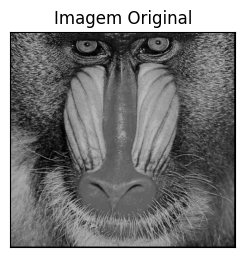

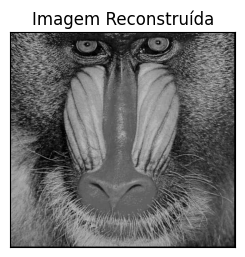

RMSE: 11.549
PSNR: 26.880


In [28]:
# Exibe a imagem original utilizando o matplotlib
plt.subplot(121), plt.imshow(img, cmap='gray', clim=(0, 255))  # Plota a imagem original em escala de cinza
plt.title('Imagem Original')  # Define o título da imagem
plt.xticks([]), plt.yticks([])  # Remove as marcações dos eixos x e y para melhor visualização
plt.show()  # Exibe a imagem

# Exibe a imagem reconstruída após a IDCT
plt.subplot(121), plt.imshow(IDCT_matrix, cmap='gray', clim=(0, 255))  # Plota a imagem reconstruída após IDCT
plt.title('Imagem Reconstruída')  # Define o título da imagem reconstruída
plt.xticks([]), plt.yticks([])  # Remove as marcações dos eixos x e y
plt.show()  # Exibe a imagem reconstruída

# Calcula o erro quadrático médio (RMSE) entre a imagem original e a imagem reconstruída
print("RMSE: %5.3f" % rmse(img, IDCT_matrix))  # Exibe o valor do RMSE (Root Mean Square Error)

# Calcula o pico da razão sinal-ruído (PSNR) entre a imagem original e a imagem reconstruída
print("PSNR: %5.3f" % psnr(img, IDCT_matrix))  # Exibe o valor do PSNR (Peak Signal-to-Noise Ratio)

# ANÁLISE DE RESULTADOS

## RESULTADOS FINAIS
Para a análise de resultados, iremos comparar os valores de RMSE (Root Mean Squared Error), PSNR (Peak Signal-to-Noise Ratio) e a Taxa de Compressão obtidos para as diferentes imagens, visto que essas métricas fornecem uma boa medida de desempenho da compressão aplicada.

Para a imagem da mulher (lena512.pgm), o valor obtide de RMSE foi de 4,595, o que indica uma diferença um pouco perceptível entre a imagem original e a comprimida. O PSNR obtido de 34,885 indica que a compressão preservou a maior parte da qualidade da imagem, embora haja uma pequena perda visível devido à redução de dados. Essa imagem possui algumas áreas de complexidade visual um pouco mais alta, como os detalhes do chapéu e o cabelo, que são mais sensíveis a perdas de informação. Por outro lado, possui algumas áreas relativamente uniformes e gradientes mais suaves como a superfície da pele da mulher e a parte interna das paredes ao fundo, resultando assim em um PSNR aceitável.

Para a imagem do escritório (unequal.pgm), que aparenta ter sido opacificada e apresenta pouco contraste, o RMSE obtido foi de 2,400 e o PSNR obtido obtido foi de 40,526, indicando que a compressão foi mais eficiente, com uma diferença menor entre a imagem original e a comprimida. O PSNR mais alto, neste caso, pode ser explicado pela menor complexidade visual da cena, com menos detalhes finos que poderiam ser afetados pela compressão. Além disso, a presença do efeito de opacidade e baixo constraste faz com que as perdas de detalhes sejam menos perceptíveis ao olho humano, resultando em um PSNR melhor.

A imagem do fotógrafo (cameraman.pgm) apresentou um RMSE de 9,022 e um PSNR de 29,024, consideravelemente pior do que as outras imagens testadas. Esse resultado pode ser explicado a partir da composição da imagem, que possui uma maior quantidade de detalhes, principalmente na região onde está a câmera, e também possui regiões com um alto contraste (transições menos suaves de tons de cinza) como entre a paisagem ao fundo (clara) e a roupa utilizada pelo fotógrafo (escura). Essa composição torna mais difícil uma conversão sem perda de qualidade.

A imagem do babuíno (baboon.pgm) apresentou um RMSE de 11,549 e um PSNR de 26,880, uma qualidade de compressão significativamente mais baixa do que as outras imagens. Devido a riqueza de detalhes presentes na imagem, como a complexa textura da pele e pelos do babuíno, já era esperado que essa imagem obtivesse resultados piores do que as outras, já que esses detalhes dificultam uma compressão sem perda de qualidade.

A riqueza dos detalhes e a complexidade das texturas também afetaram a taxa de compressão da imagens testadas. As imagens do fotógrafo e do babuíno apresentaram uma taxa de compressão próxima de 5: 5,611 e 4,755 respectivamente. Enquanto isso, a imagem da mulher apresentou uma taxa de compressão de 9,217 e a imagem do escritório apresentou uma taxa de compressão de 17,232. Apesar das diferenças de valores, todas as imagens apresentaram uma boa taxa de compressão, acima de 4.

## RESULTADOS INTERMEDIÁRIOS

A maior parte da perda de dados durante a compressão ocorre no processo de quantização, os valores escolhidos para a matriz de quantização determinam quais faixas de frequência serão priorizadas (alta frequência ou baixa frequência), afetando a taxa de compressão que será obtida. 

A matriz de quantização utilizada nesse trabalho foi a **padrão do JPEG** para a compressão de **qualidade média**. Para efeitos de teste, aplicamos também uma matriz de quantização para compressão suave com valores menores e a qualidade da compressão apresentou uma melhora considerável. Em contrapartida, a taxa de compressão diminuiu. Os valores obtidos podem ser observados na tabela abaixo.


| Imagem           | RMSE  (Matriz 1 /Matriz 2)  | PSNR (dB) (Matriz 1 / Matriz 2) | Taxa de Compressão (Matriz 1/Matriz2) |
|------------------|-----------------------------|---------------------------------|--------------------------------------|
| Mulher           | 4.595 / 3,821               | 34.885 / 36,488                 | 9,217 / 5,624                         | 
| Escritório       | 2.400 / 1,939               | 40.526 / 42,378                 | 17,232 / 10,486                       |
| Fotógrafo        | 9.022 / 8,131               | 29.024 / 29,927                 | 5,611 / 3,616                         |
| Babuíno          | 11.549 / 10,337             | 26.880  / 27,843                | 4,755 / 3,443                         |
|(Matriz 1: padrão JPEG; Matriz 2: compressão suave)                                                                       |

Como é possível observar, a matriz de compressão suave, que prioriza as baixas frequências, apresentou taxas de RMSE mais baixas e taxas de PSNR mais altas para todas as imagens, isso ocorre pois os detalhes mais importantes da imagem estão concentrados nessas baixas frequências, isto é, nos coeficientes do canto superior esquerdo da matriz de saída do DCT. Apesar disso, as taxas de compressão das imagens foram significativamente reduzidas.

Optamos por continuar utilizando a matriz padrão do JPEG pois os ganhos obtidos na qualidade da imagem comprimida na matriz de compressão suave foram menos significativos do que as perdas obtidas na taxa de compressão.

# CONCLUSÃO

A análise dos parâmetros de desempenho, como RMSE, PSNR e taxa de compressão, evidenciou que a maior parte da perda ocorre durante a etapa de quantização. Isso foi confirmado ao comparar a matriz padrão do JPEG com uma matriz de compressão suave. Embora a matriz de compressão suave tenha apresentado melhores resultados em termos de qualidade (menor RMSE e maior PSNR), isso ocorreu às custas de uma redução significativa na taxa de compressão. A escolha pela matriz padrão do JPEG, portanto, representou um equilíbrio mais adequado entre qualidade da imagem comprimida e eficiência de compressão, atendendo aos objetivos propostos.

Durante a execução deste trabalho ficou clara a importância de uma escolha criteriosa dos parâmetros do algoritmo, principalmente na etapa de quantização, pois essa decisão impacta diretamente o desempenho do sistema em diferentes cenários. Além disso, a implementação reforçou os fundamentos teóricos sobre compressão de imagens e mostrou como métodos clássicos, como a DCT e a codificação de Shannon-Fano, ainda podem ser utilizados de forma eficiente em tarefas de compressão.

O método utilizado conseguiu atingir seu objetivo de reduzir o tamanho das imagens mantendo uma qualidade aceitável, com taxas de compressão acima de 4:1 em todos os casos testados, demonstrando a eficácia do algoritmo desenvolvido.
